# Gene Regulatory network Modeling (GRenMlin)


### Libraries

All the required code is implemented in `grn.py` (manipulation of a gene regulatory network, GRN) and `simulator.py` (running the simulations of a constructed network).


In [4]:
import src.simulator as simulator
import src.grn as grn
import numpy as np

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constructing the network

Construction of the network is relatively straightforward. First, we need to call a constructor:


In [6]:
my_grn = grn.GRN()

In the next step, we can add different species. Input species do not degrade, while for all other (ordinary) species degradation rate needs to be specified.


In [7]:
# input species
my_grn.add_input_species("X1")
my_grn.add_input_species("X2")

# other species
my_grn.add_species("Y", 0.1)


In the next step we can add a gene, which will be defined by a set of regulators and a set of products.

The first gene will describe the function `not X1 and X2`


In [8]:
# regulators of a gene
regulators = [
    {"name": "X1", "type": -1, "Kd": 5, "n": 2},
    {"name": "X2", "type": 1, "Kd": 5, "n": 3},
]
# products of a gene
products = [{"name": "Y"}]

# adding a gene to the network - the first parameter specifies the rate of gene expression
my_grn.add_gene(10, regulators, products)

Similarly, we can add another gene. The second gene will describe the function `X1 and not X2`. Since both genes will produce the same output (`Y`) the network will implement `Y = (not X1 and X2) OR (X1 and not X2) = X1 XOR X2`.


In [9]:
regulators = [
    {"name": "X1", "type": 1, "Kd": 5, "n": 2},
    {"name": "X2", "type": -1, "Kd": 5, "n": 3},
]
products = [{"name": "Y"}]
my_grn.add_gene(10, regulators, products)

We can check which genes are in the network:


In [10]:
my_grn.genes

[{'alpha': 10,
  'regulators': [{'name': 'X1', 'type': -1, 'Kd': 5, 'n': 2},
   {'name': 'X2', 'type': 1, 'Kd': 5, 'n': 3}],
  'products': [{'name': 'Y'}],
  'logic_type': 'and'},
 {'alpha': 10,
  'regulators': [{'name': 'X1', 'type': 1, 'Kd': 5, 'n': 2},
   {'name': 'X2', 'type': -1, 'Kd': 5, 'n': 3}],
  'products': [{'name': 'Y'}],
  'logic_type': 'and'}]

or plot the network (**red** arrows represent inhibition, **blue** arrows represent activation, and **orange** arrows represent both):


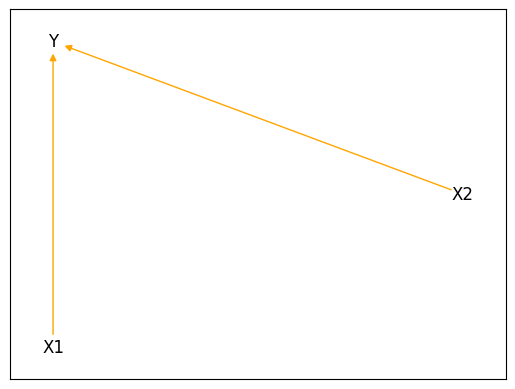

In [11]:
my_grn.plot_network()

Finally, we can run some simulations to test the dynamics of the established network:


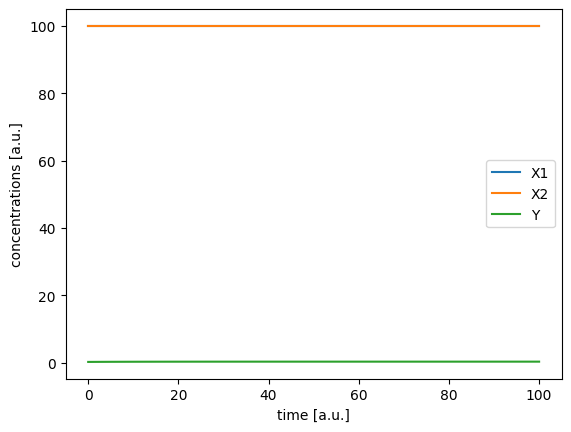

In [12]:
# specify inputs

IN = np.zeros(len(my_grn.input_species_names))
IN[0] = 100
IN[1] = 100

T, Y = simulator.simulate_single(my_grn, IN)

The simulations can also be performed for a sequence of inputs. In this case, we also need to specify for how long each input combination will be held (`t_single`).


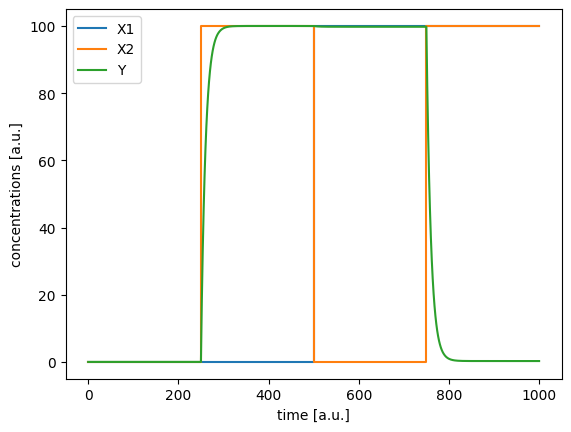

In [13]:
T, Y = simulator.simulate_sequence(
    my_grn, [(0, 0), (0, 100), (100, 0), (100, 100)], t_single=250
)

We can observe the following dynamics:

- For the first 250 time units, both inputs (`X1` and `X2`) are absent (logical 0) and so is the output (`Y`).
- The next 250 time units (from `t=250 a.u.` to `t=500 a.u.`) the first input (`X1`) is absent (logical 0) and the second output (`X2`) is present (logical 1). This activates the output (`Y`).
- The next 250 time units (from `t=500 a.u.` to `t=750 a.u.`) the first input (`X1`) is present (logical 1) and the second output (`X2`) is absent (logical 0). This activates the output (`Y`).
- The last 250 time units (from `t=750 a.u.` to `t=1000 a.u.`) both inputs (`X1` and `X2`) are present (logical 1). This inactivates the output (`Y`).
